# TF to Torch Conversion

## Purpose
- Weight transfer
- Torch Reproducibility debugging

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import tensorflow as tf
import gdown
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm

from torch import nn
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity

# local code
from synthmorph import layers, networks, datamodule as dm, utils

2023-10-27 07:43:22.202931: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 07:43:22.256439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Prevent TF model from taking whole GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-10-27 07:43:25.718390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 07:43:25.725145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 07:43:25.725473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Transfer Weights TF -> Torch

In [4]:
# Define fresh Torch model
vol_size = (256,) * 2
unet_enc_nf = [256] * 4
unet_dec_nf = [256] * 8
int_steps = 7 
int_downsize = 2
bidir = False
torch_vxmdense = networks.VxmDense(
    inshape=vol_size,
    nb_unet_features=[unet_enc_nf, unet_dec_nf],
    int_steps=int_steps,
    int_downsize=int_downsize,
    bidir=bidir,
    unet_half_res=True,
)

torch_weights = torch_vxmdense.state_dict()

In [5]:
# Define fresh Keras model
# This section is just a copy of the orginal demo to define the Keras model

# Label maps
in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 16
num_maps = 1
label_maps = []
for _ in range(num_maps):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab))

# Image generator
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)

# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256] * 4, [256] * 8),
    reg_field='warp',
)

# Model for optimization.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)

2023-10-27 07:43:35.888219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 07:43:35.888627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 07:43:35.888905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# Load Keras pretrained weights
gdown.download('https://drive.google.com/uc?id=1xridvtyEWgWsWJPYVrQfDCtSgbj2beRz', 'weights.h5')
model.load_weights('weights.h5')

# Extract weights from the registration model only
keras_vxmdense = reg_model   
keras_weights = {w.name: (w.numpy(), w.dtype, w.shape) for w in keras_vxmdense.weights}

Downloading...
From: https://drive.google.com/uc?id=1xridvtyEWgWsWJPYVrQfDCtSgbj2beRz
To: /home/jovyan/synthmorph-torch/weights.h5
100%|█████████████████████████████████████████████████████████████████████████████████████| 33.2M/33.2M [00:01<00:00, 24.1MB/s]


In [7]:
# Only get kernel weights
keras_weights_keys = list(keras_weights.keys())
keras_kernels = [string for string in keras_weights_keys if 'bias' not in string]
keras_kernels

['vxm_dense_unet_enc_conv_0_0/kernel:0',
 'vxm_dense_unet_enc_conv_1_0/kernel:0',
 'vxm_dense_unet_enc_conv_2_0/kernel:0',
 'vxm_dense_unet_enc_conv_3_0/kernel:0',
 'vxm_dense_unet_dec_conv_3_0/kernel:0',
 'vxm_dense_unet_dec_conv_2_0/kernel:0',
 'vxm_dense_unet_dec_conv_1_0/kernel:0',
 'vxm_dense_unet_dec_conv_0_0/kernel:0',
 'vxm_dense_unet_dec_final_conv_0/kernel:0',
 'vxm_dense_unet_dec_final_conv_1/kernel:0',
 'vxm_dense_unet_dec_final_conv_2/kernel:0',
 'vxm_dense_unet_dec_final_conv_3/kernel:0',
 'vxm_dense_flow/kernel:0']

In [8]:
new_weights = {}

# Transfer the weights (the order of layers are the same)
for k,t in zip(keras_weights.keys(), torch_weights.keys()):
    if k in keras_kernels:
        new_weights[t] = torch.Tensor(np.moveaxis(keras_weights[k][0], [-1, -2], [0, 1]))
    else:
        new_weights[t] = torch.Tensor(keras_weights[k][0])

torch_vxmdense.load_state_dict(new_weights)
# torch.save(torch_vxmdense.state_dict(), 'vte/experiments/voxel_morph/model/keras_torchflow_weights.pth')  # uncomment to save weights

<All keys matched successfully>

## Weight Transfer and PyTorch Reimplementation Debug

In [9]:
custom_keras_layers = keras_vxmdense.layers[:]
custom_keras_model= Model(
    inputs=keras_vxmdense.inputs, 
    outputs=custom_keras_layers[-1].output,
)

In [16]:
# Conform test data
def tf_conform(x, in_shape=in_shape):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = np.squeeze(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

In [17]:
# Load MNIST in TF
images, digits = tf.keras.datasets.mnist.load_data()[-1]
ind = np.flatnonzero(digits == 5)
moving = tf_conform(images[ind[223]])
fixed = tf_conform(images[ind[199]])

In [20]:
# Test layers and modules one by one
unet_torch = torch_vxmdense.unet_model
flow_torch = torch_vxmdense.flow
vecint_torch = torch_vxmdense.integrate
rescale_torch = torch_vxmdense.fullsize
spatial_torch = torch_vxmdense.transformer
custom_torch_model = nn.Sequential(
    unet_torch, 
    flow_torch, 
    vecint_torch,
    rescale_torch,
    spatial_torch,
)
custom_torch_model = custom_torch_model.eval().cuda()

In [21]:
def preprocess_torch(x):
    x = torch.from_numpy(x)
    x = x.to('cuda')
    x = x.permute(0, 3, 1, 2)
    return x

In [22]:
torch_conform = lambda x, y: dm.conform(x, y)
torch_moving = torch_conform(moving, (256,256))
torch_moving = preprocess_torch(torch_moving)
torch_fixed = torch_conform(fixed, (256,256))
torch_fixed = preprocess_torch(torch_fixed)

torch_unet_input = torch.cat([torch_moving, torch_fixed], dim=1)

### SSIM of TF vs Torch

In [39]:
keras_output = keras_vxmdense.predict((moving, fixed))
keras_source, keras_flow = keras_output

keras_flow = keras_flow.transpose(0, 3, 1, 2)
keras_source = keras_source.transpose(0, 3, 1, 2)

1/1 [==============================] - 0s 30ms/step


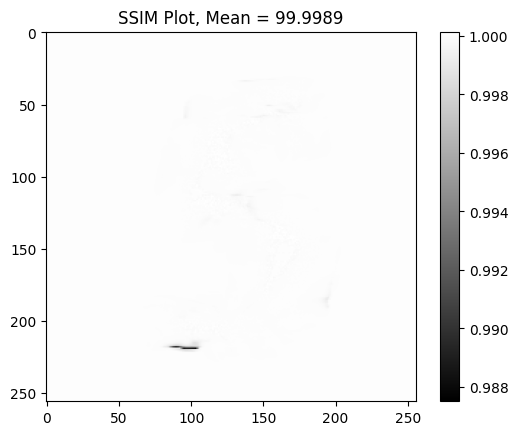

In [76]:
# SSIM is not 100% but good enough
# If you are doing SSIM on flow, do it one axis at a time
keras_compare = keras_source  
torch_output = torch_vxmdense(torch_moving, torch_fixed)['y_source']    # y_source refers to registered image
torch_output = torch_output.cpu().detach().numpy()
torch_output = torch_output.squeeze()

data_range = torch_output.max() - torch_output.min()
channel_axis = 0 if torch_output.ndim > 2 else None
ssim_mean, ssim_full= structural_similarity(
    torch_output, 
    keras_compare.squeeze(),
    win_size=11,    # must be odd
    data_range=data_range,
    channel_axis=0,
    multichannel=True,
    full=True,
)
plt.imshow(ssim_full, cmap="gray")
plt.title(f"SSIM Plot, Mean = {ssim_mean*100:.4f}")
plt.colorbar()
plt.show()